In [4]:
import pandas as pd
import numpy as np
import torch
import re
import tqdm
from matplotlib._path import (affine_transform, count_bboxes_overlapping_bbox,
     update_path_extents)

In [5]:
dataset=pd.read_csv('/content/dataset.csv')
dataset.dropna(inplace = True)
dataset

,id,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [6]:
print("number of tweets belonging to classes 0,1 and 2")
dataset.groupby('class')['id'].nunique()


number of tweets belonging to classes 0,1 and 2


class
0     1430
1    19190
2     4163
Name: id, dtype: int64

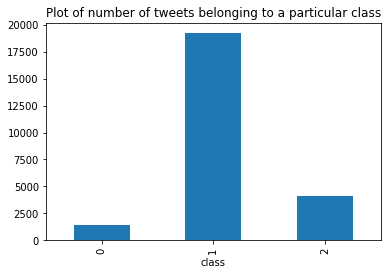

In [7]:
dataset.groupby('class')['id'].nunique().plot(kind='bar',title='Plot of number of tweets belonging to a particular class')

# **Data Cleaning**

In [8]:
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
stop_words= set(stopwords.words('english'))

In [11]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
def clean_tweet(tweet):
    tweet = re.sub("#", "",tweet) # Removing '#' from hashtags
    tweet = re.sub("[^a-zA-Z#]", " ",tweet) # Removing punctuation and special characters
    tweet = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+',"<URL>", tweet)
    tweet = re.sub('http','',tweet)
    tweet = re.sub(" +", " ", tweet)
    tweet = tweet.lower()
    tweet = word_tokenize(tweet)
    return_tweet=[]
    for word in tweet:
        if word not in stop_words:
            return_tweet.append(word)
    return return_tweet
dataset["tweet"]=dataset["tweet"].apply(clean_tweet)


# **Word2Vec model to get the word embedings.**

In [13]:
model = Word2Vec(dataset["tweet"].values, size=50, window=5, min_count=1, workers=4)

In [14]:
def get_features(tweet):
    features=[]
    for word in tweet:
        features.append(model.wv[word])
    return np.mean(features,0)

In [15]:
dataset["features"]=dataset["tweet"].apply(get_features)

In [16]:
data=[]
for i in dataset["features"].values:
    temp=[]
    for j in i:
        temp.append(j)
    data.append(temp)
data=np.array(data)

In [17]:
from sklearn.preprocessing import label_binarize

Y = label_binarize(dataset["class"].values, classes=[0, 1, 2])
n_classes = Y.shape[1]
X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size=0.2, random_state=42)

In [18]:
print(X_train)
print(y_train)

[[-0.18939352 -0.29217657  1.0014933  ... -0.5365136   1.2946599
  -1.2960353 ]
 [-0.23240569 -0.33105832  1.1710222  ... -0.6212086   1.4974866
  -1.5281309 ]
 [-0.19918238 -0.31201515  0.997039   ... -0.5310282   1.3149744
  -1.3003778 ]
 ...
 [-0.18261968 -0.15744427  0.7406542  ... -0.40562263  0.9375454
  -0.8821841 ]
 [-0.15627395 -0.22645141  0.796249   ... -0.41885066  1.0272974
  -1.0383884 ]
 [-0.2604522  -0.49143434  1.4396456  ... -0.8079615   1.9611034
  -1.9045855 ]]
[[1 0 0]
 [0 0 1]
 [0 1 0]
 ...
 [0 1 0]
 [0 1 0]
 [0 1 0]]


# **LOGISTIC REGRESSION MODEL**

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

F1 Score:  0.84101715939632
Precision Score:  0.8624125503497986
Recall Score:  0.820657655840226
Accuracy:  0.8202541859995965


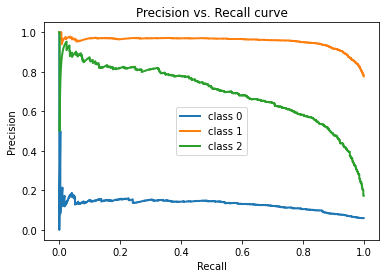

In [20]:
lr_clf = OneVsRestClassifier(LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial'))
lr_clf.fit(X_train,y_train)
y_pred = lr_clf.predict(X_test)
f = f1_score(y_test, y_pred, average='micro')
print("F1 Score: ", f)
p = precision_score(y_test, y_pred, average='micro')
print("Precision Score: ", p)
r = recall_score(y_test, y_pred, average='micro')
print("Recall Score: ", r)
print("Accuracy: ", lr_clf.score(X_test,y_test))

y_score = lr_clf.predict_proba(X_test)
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc = "best")
plt.title("Precision vs. Recall curve")
plt.show()

# ***SVM MODEL***

F1 Score:  0.8083463745435577
Precision Score:  0.8370786516853933
Recall Score:  0.7815210812991729
Accuracy:  0.7815210812991729


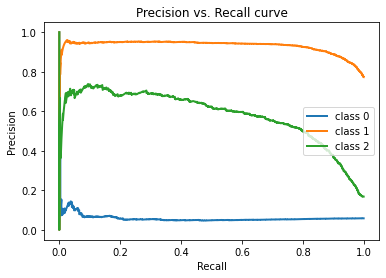

In [21]:
svm_clf = OneVsRestClassifier(svm.SVC(gamma='scale', probability=True))
svm_clf.fit(X_train,y_train)
y_pred = svm_clf.predict(X_test)
f = f1_score(y_test, y_pred, average='micro')
print("F1 Score: ", f)
p = precision_score(y_test, y_pred, average='micro')
print("Precision Score: ", p)
r = recall_score(y_test, y_pred, average='micro')
print("Recall Score: ", r)
print("Accuracy: ", svm_clf.score(X_test,y_test))

y_score = svm_clf.predict_proba(X_test)
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc = "center right")
plt.title("Precision vs. Recall curve")
plt.show()